In [7]:
from __future__ import division
#import pylion as pl
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt, numpy as np, scipy.constants as ct
from mpl_toolkits.mplot3d import Axes3D
from electrode import (System, PolygonPixelElectrode, PointPixelElectrode, shaped)

import sion as sn

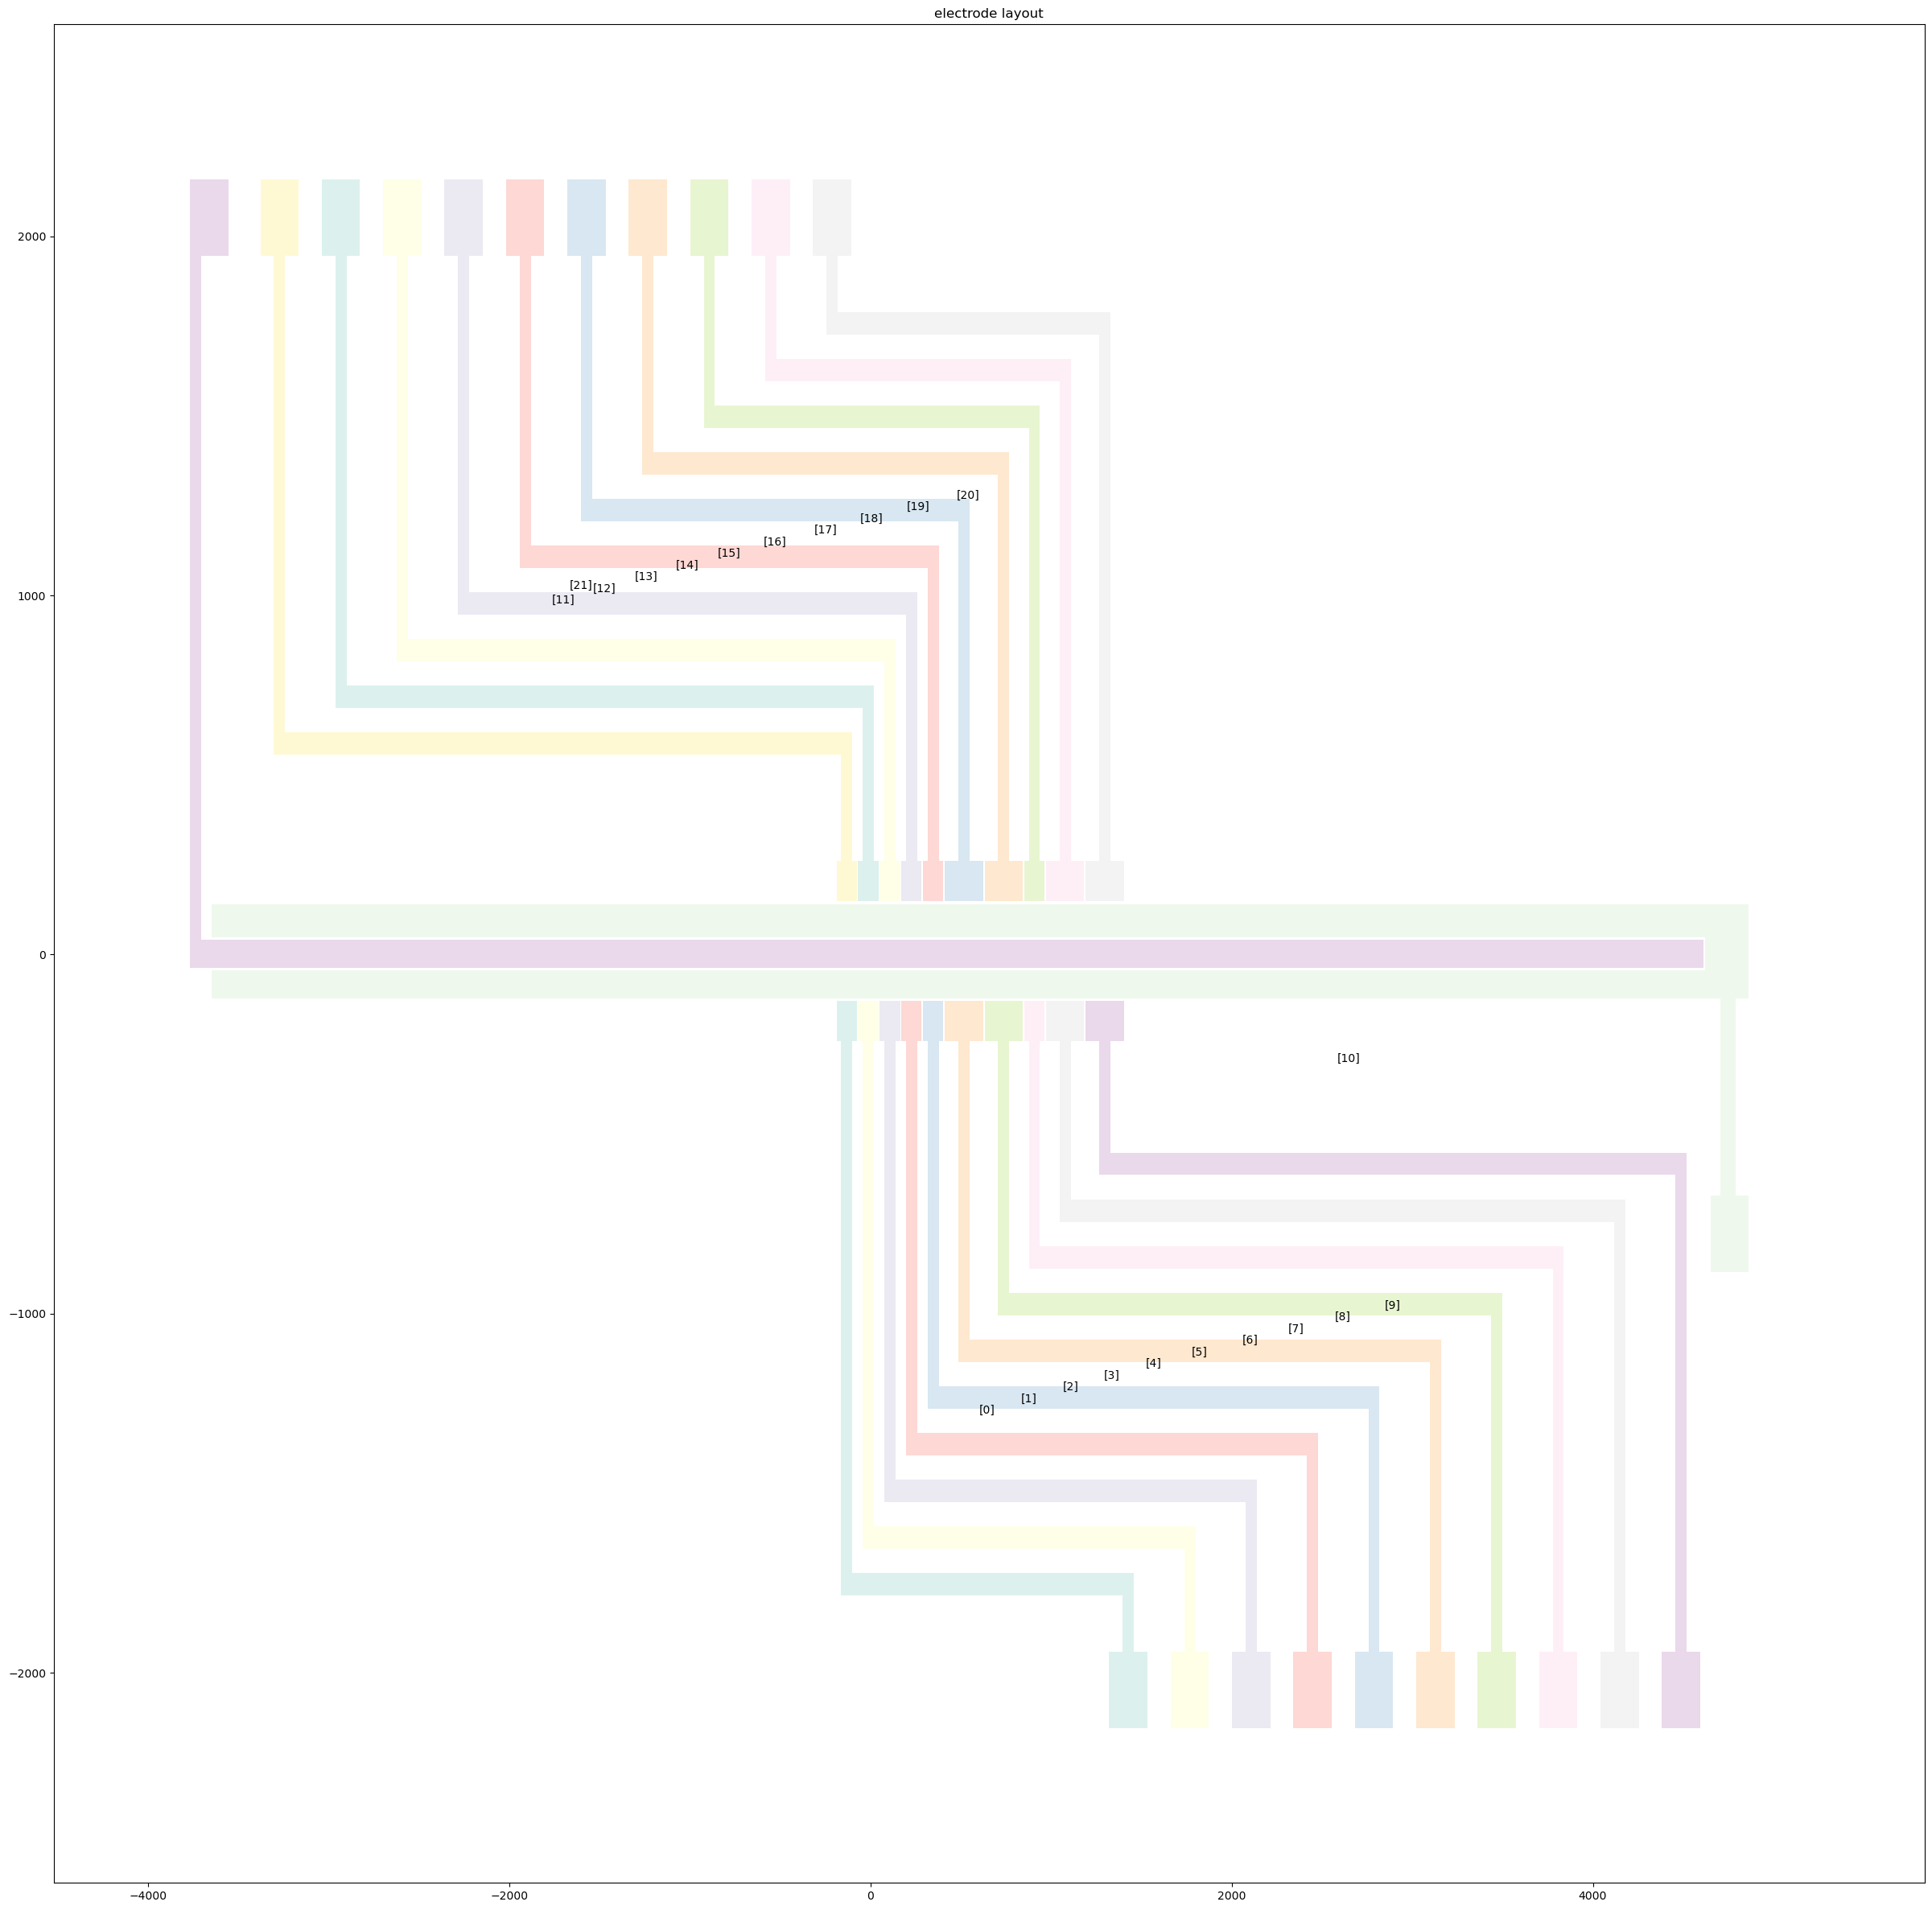

In [8]:
L = 1e-6 # µm length scale
s, full_electrode_list = sn.polygons_from_gds('test1.GDS', need_plot = True, need_coordinates = True, L=L)

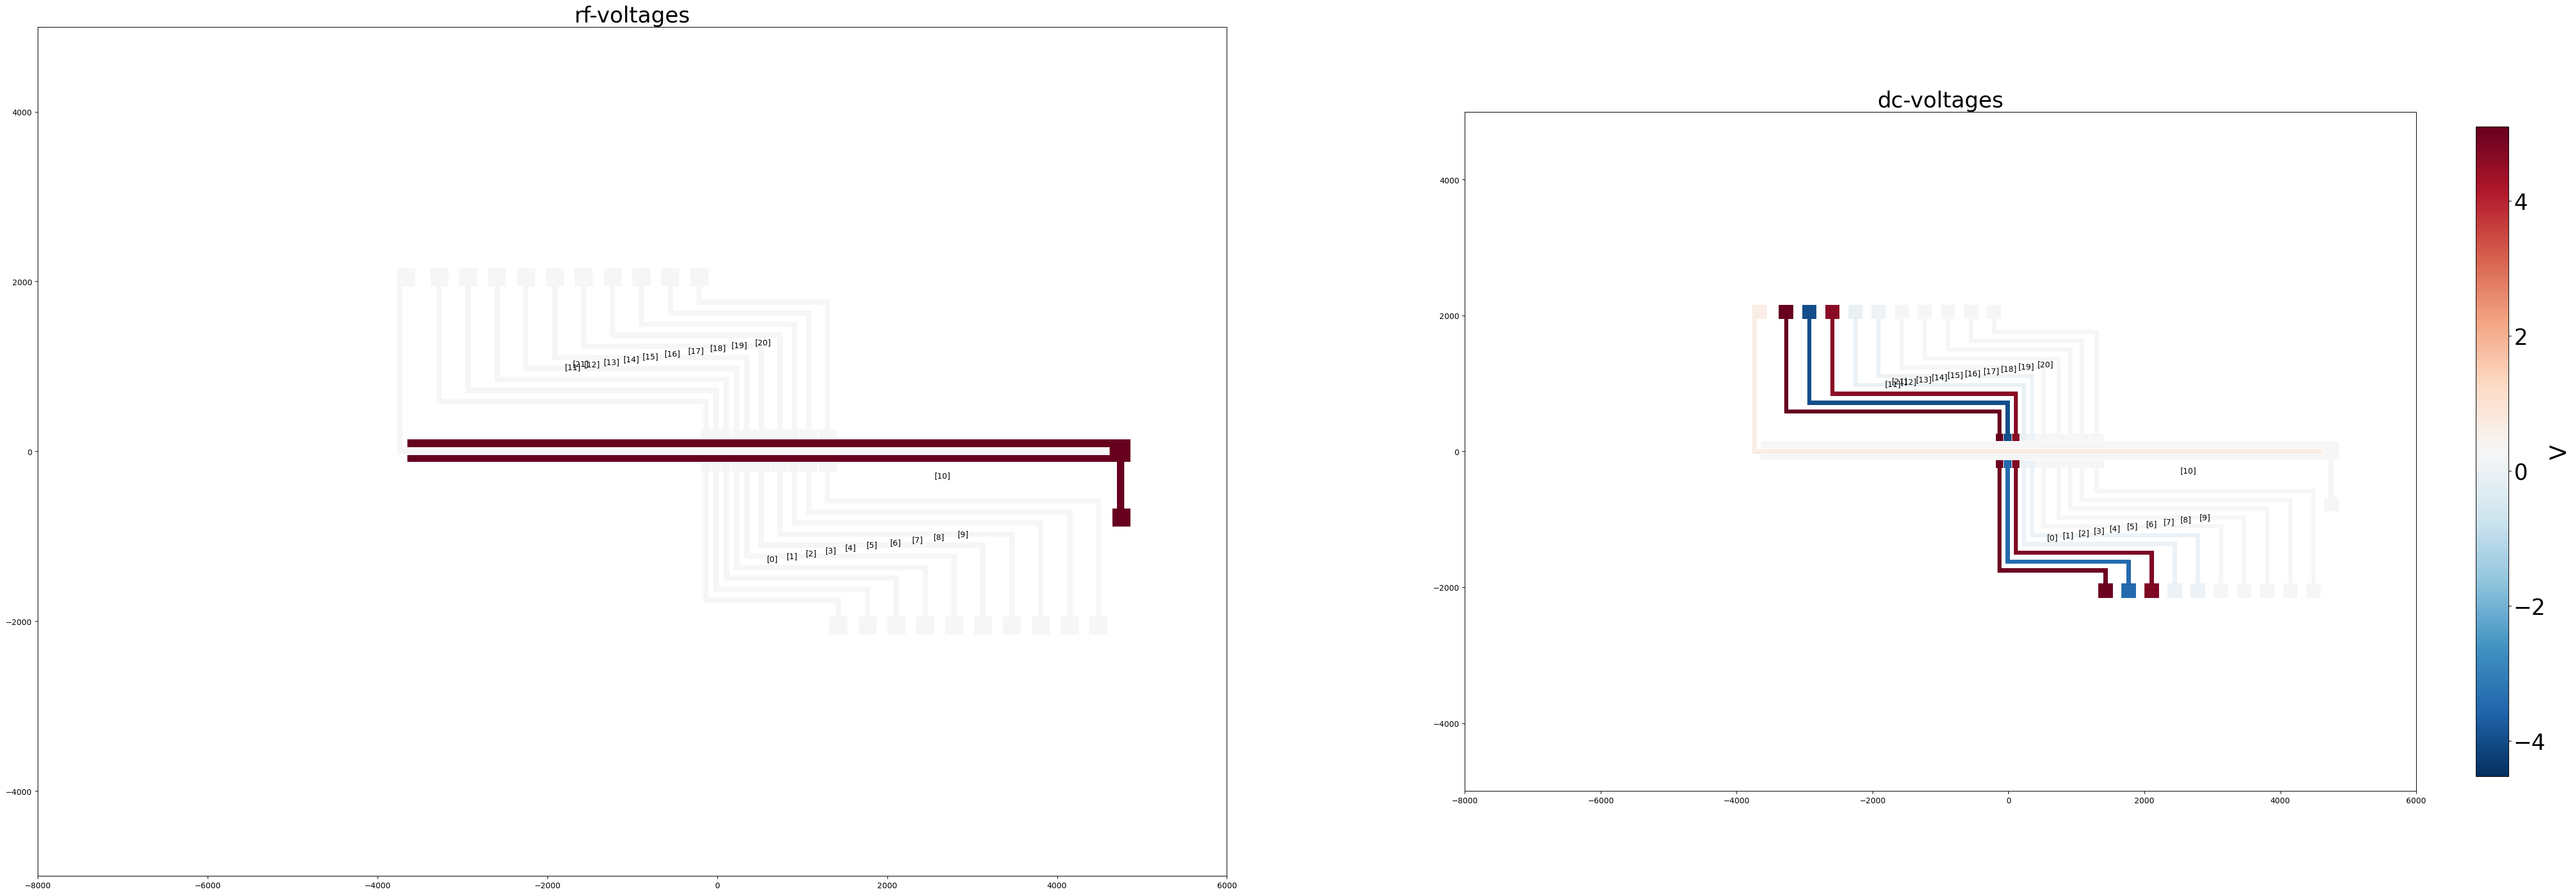

In [212]:
# Global definition of trap parameters. Used for all cells in this notebook
Vrf = 50. # RF peak voltage in V
M = 40*ct.atomic_mass # ion mass
Z = 1*ct.elementary_charge # ion charge
Omega = 2*np.pi*30e6 # RF frequency in rad/s
# RF voltage in parametrized form so that the resulting potential equals the RF pseudopotential in eV
Urf = Vrf*np.sqrt(Z/M)/(2*L*Omega)

RF_electrodes = [full_electrode_list[10]]
DC_electrodes = [full_electrode_list[0:9]] + full_electrode_list[11:]


V21=0.365
V0=5
V1=-3.98
V2=4.78
V3=-0.31
V4=-0.29
############################
V5=0
V6=0
V7=0
V8=0
V9=0
#############################
V11=5.1
V12=-4.52
V13=4.59
V14=-0.34
V15=-0.31
#################################
V16=0
V17=0
V18=0
V19=0
V20=0
#########################

s.rfs = np.array([0, 0,0,0,0,0,0,0,0,0,Urf, 0, 0, 0, 0, 0, 0,0,0,0,0,0])
s.dcs = 1*np.array([V0, V1, V2, V3, V4, V5, V6, V7, V8, V9, 0, V11, V12, V13, V14, V15, V16, V17, V18, V19, V20, V21])
#rf_set = [Vrf]
#dc_set = [V0, V1, V2, V3, V4, V5, V6]
omegas = [Omega]

fig, ax = plt.subplots(1, 2, figsize=(60, 30))
s.plot_voltages(ax[0], u=s.rfs)
s.plot_voltages(ax[1], u=s.dcs)
ax[0].set_title("rf-voltages", fontsize = 28)
# ax[0] addresses the first plot in the subplots - set_title gives this plot a title
ax[1].set_title("dc-voltages", fontsize = 28)
for axi in ax.flat:
    axi.set_aspect("equal")
    axi.set_xlim(-8000, 6000)
    axi.set_ylim(-5000, 5000)
cmap = plt.cm.RdBu_r
norm = mpl.colors.Normalize(vmin=np.min(s.dcs), vmax=np.max(s.dcs))

cb = fig.colorbar(plt.cm.ScalarMappable(norm = norm, cmap=cmap),ax=axi,orientation = 'vertical', shrink =0.5, pad = 0.05)

cb.ax.tick_params(labelsize=28)
cb.set_label('V', fontsize = 28)

In [213]:
with s.with_voltages(dcs = np.zeros(22), rfs = None):
    x0 = s.minimum([0,1.5,75], axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG")

x1 = s.minimum(x0, axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG")
print('The minimum is (%.3g, %.3g, %.3g)' % (x1[0], x1[1], x1[2]))
print('The RF minimum is (%.3g, %.3g, %.3g)' % (x0[0], x0[1], x0[2]))
print('Distance from RF-minimum: (%.3g, %.3g, %.3g)' % (x1[0] - x0[0], x1[1] - x0[1], x1[2] - x0[2]))

The minimum is (-4.09, -2.19, 76.7)
The RF minimum is (-3.07e-05, -2.12, 77.7)
Distance from RF-minimum: (-4.09, -0.0718, -1.04)


In [214]:

# Get trap frequencies
try:
    curv_z, mod_dir=s.modes(x1,sorted=False)
    omega_sec=np.sqrt(Z*curv_z/M)/(L*2*np.pi) * 1e-6
    print("Secular frequencies: (%.4g, %.4g, %.4g) MHz" % (omega_sec[0],omega_sec[1],omega_sec[2]))
    print("In directions\na:", mod_dir[0],"\nb:", mod_dir[1],"\nc:", mod_dir[2] )
    e1 = np.array([0,0,1])
    alp = np.arccos(np.inner(mod_dir[2],e1))
    print('Angle of secular modes rotation alpha:', alp)
except:
    print("Secular frequencies not found")


Secular frequencies: (0.9208, 2.919, 3.526) MHz
In directions
a: [ 0.9999401  -0.00990796 -0.00464988] 
b: [ 0.00951731  0.99693824 -0.07761158] 
c: [0.00540462 0.07756267 0.99697283]
Angle of secular modes rotation alpha: 0.07782929421377528


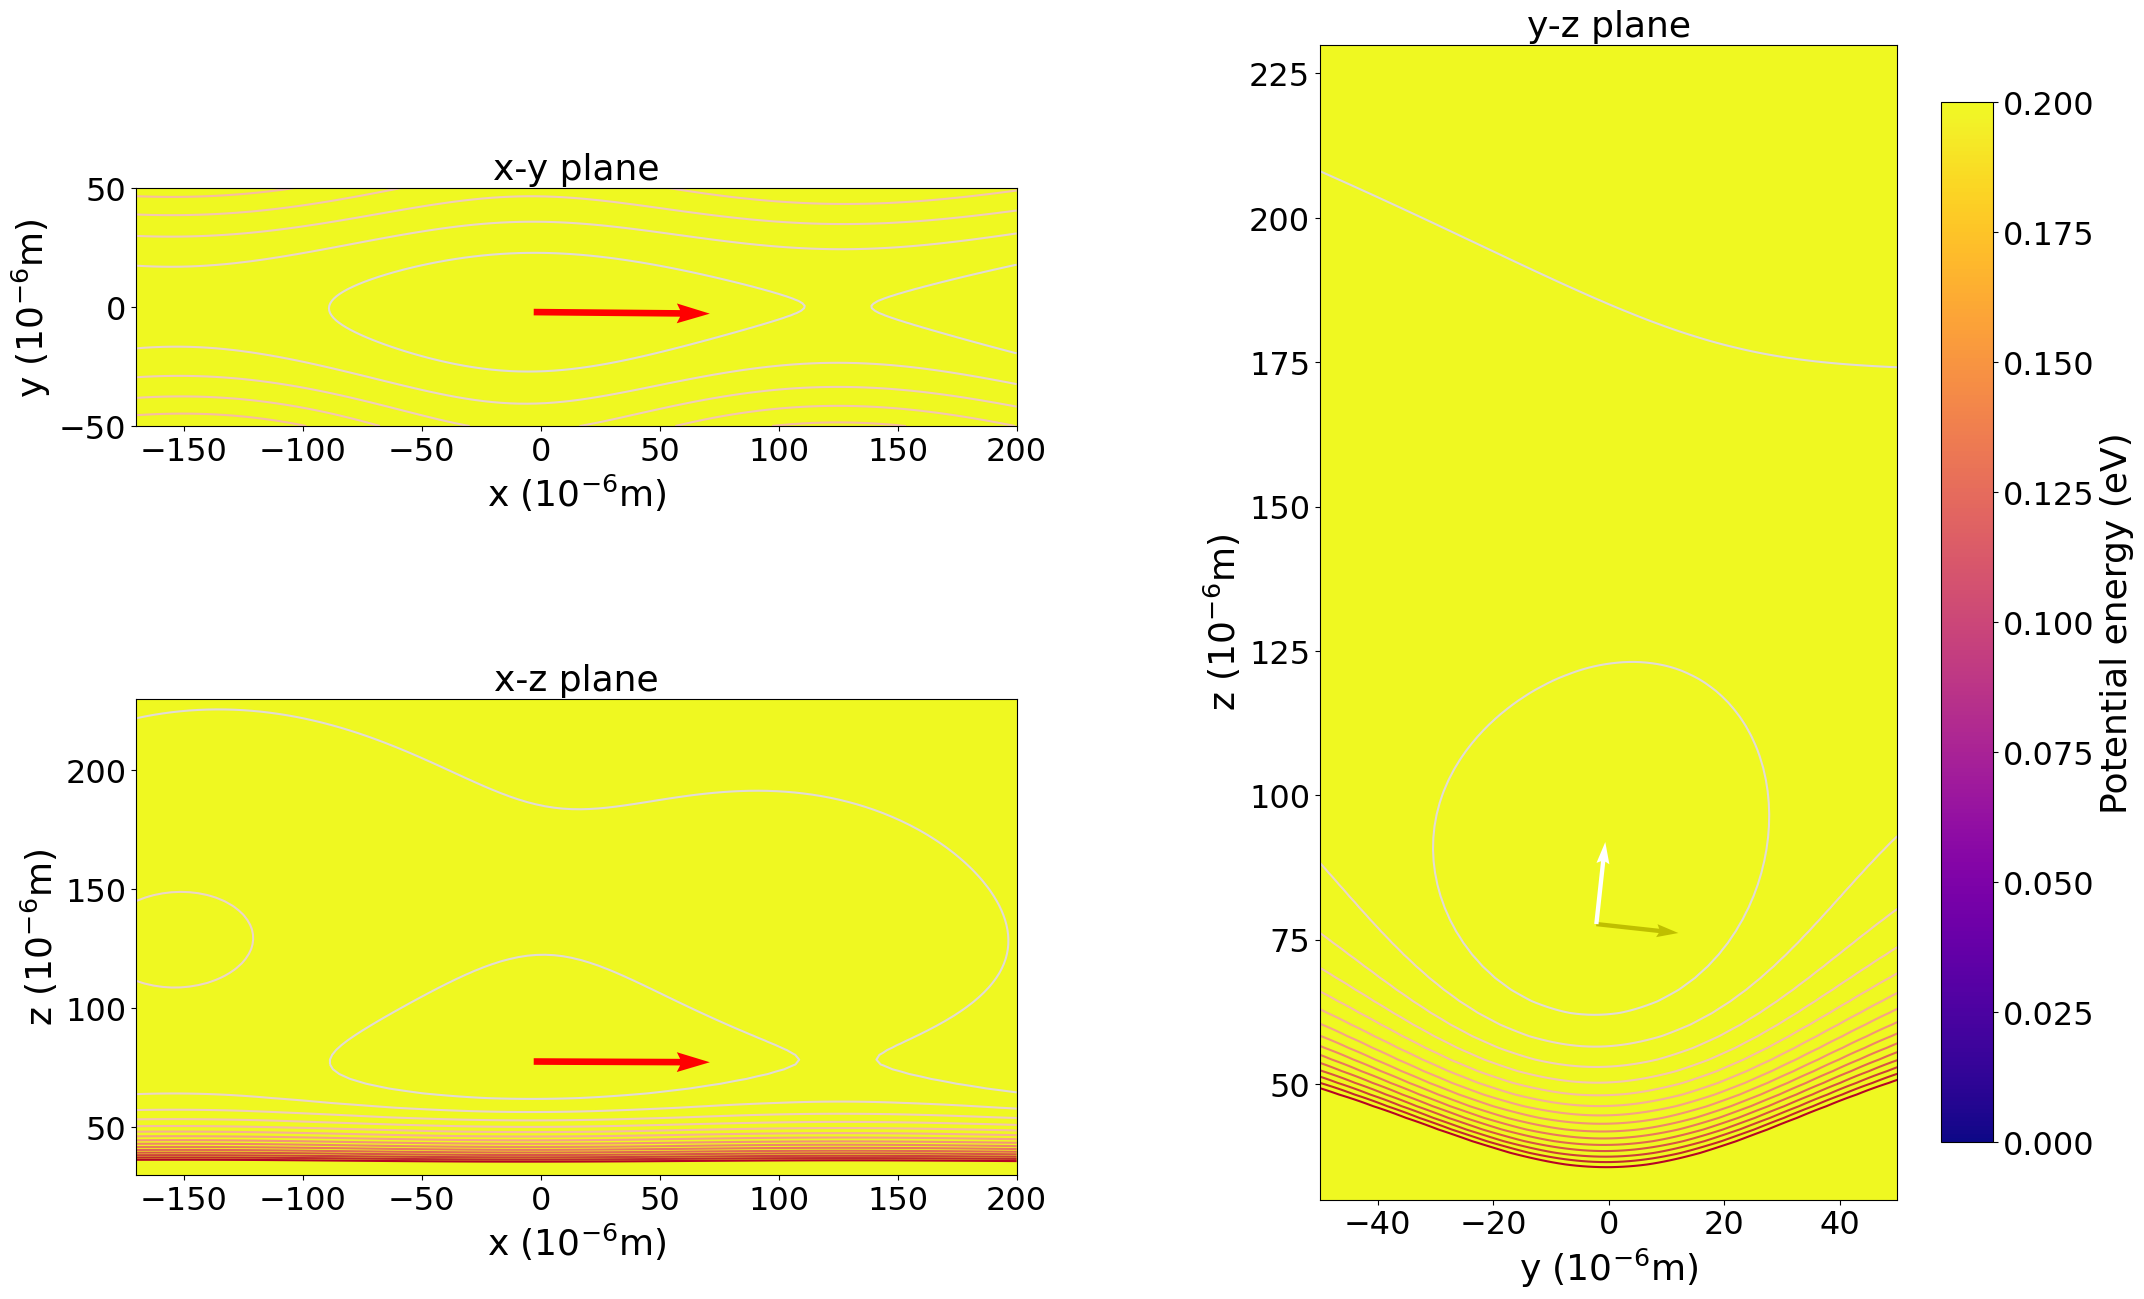

In [196]:
n=100 # resolution of meshgrid = resolution of 2D plots
xmin, xmax = -170, 200 #set the plot ranges
ymin, ymax = -50, 50
zmin, zmax = 30, 230
x_cut, y_cut, z_cut = x1[0], x1[1], x1[2]# position of the yz-, xz-, xy- crossection
v = np.arange(-0.5, 1, 0.05)# set the range for contour lines (range in eV)
v_min, v_max = 0, 0.2 # set the range for colour map (range in eV)
fs = 26 #set the fontsize
ls = 23 #set the labelsize
fig = plt.figure()
fig.set_size_inches(25,15)

# x-y cross section
ax1 = plt.subplot2grid((2,2), (0,0))
ax1.set_title("x-y plane" ,fontsize=fs)
ax1.set_xlabel('x ($10^{-6}$m)',fontsize=fs)
ax1.set_ylabel('y ($10^{-6}$m)',fontsize=fs)
ax1.tick_params(axis='x', labelsize=ls)
ax1.tick_params(axis='y', labelsize=ls)
xyz = np.mgrid[xmin:xmax:1j*n, ymin:ymax:1j*n, z_cut:z_cut+1]
pot = shaped(s.potential)(xyz)
x, y, p = (_.reshape(n, n) for _ in (xyz[0], xyz[1], pot))
CS=ax1.contour(x, y, p, v, cmap=plt.cm.coolwarm)
im = ax1.imshow(p.T,cmap='plasma', origin='lower', vmin=v_min, vmax=v_max, extent=(xmin,xmax,ymin,ymax))
im.set_interpolation('bilinear')

# x-z cross section
ax2 = plt.subplot2grid((2,2), (1,0))
ax2.set_title("x-z plane" ,fontsize=fs)
ax2.set_xlabel('x ($10^{-6}$m)',fontsize=fs)
ax2.set_ylabel('z ($10^{-6}$m)',fontsize=fs)
ax2.tick_params(axis='x', labelsize=ls)
ax2.tick_params(axis='y', labelsize=ls)
xyz = np.mgrid[xmin:xmax:1j*n, y_cut:y_cut+1, zmin:zmax:1j*n]
pot = shaped(s.potential)(xyz)
x, z, p = (_.reshape(n, n) for _ in (xyz[0], xyz[2], pot))
CS=ax2.contour(x, z, p, v, cmap=plt.cm.coolwarm)
im = ax2.imshow(p.T,cmap='plasma', origin='lower', vmin=v_min, vmax=v_max, extent=(xmin,xmax,zmin,zmax))
im.set_interpolation('bilinear')

# y-z cross section
ax3 = plt.subplot2grid((2,2), (0,1), rowspan=2)
ax3.set_title("y-z plane" ,fontsize=fs)
ax3.set_xlabel('y ($10^{-6}$m)',fontsize=fs)
ax3.set_ylabel('z ($10^{-6}$m)',fontsize=fs)
ax3.tick_params(axis='x', labelsize=ls)
ax3.tick_params(axis='y', labelsize=ls)
xyz = np.mgrid[x_cut:x_cut+1, ymin:ymax:1j*n, zmin:zmax:1j*n]
pot = shaped(s.potential)(xyz)
x, z, p = (_.reshape(n, n) for _ in (xyz[1], xyz[2], pot))
CS=ax3.contour(x, z, p, v, cmap=plt.cm.coolwarm)
im = ax3.imshow(p.T,cmap='plasma', origin='lower', vmin=v_min, vmax=v_max, extent=(ymin,ymax,zmin,zmax))
im.set_interpolation('bilinear') 

# add colorbar
cb = fig.colorbar(im, ax=ax3, shrink=0.9)
cb.ax.tick_params(labelsize=ls)
cb.set_label('Potential energy (eV)', fontsize = fs)

#add secular frequencies
#change color and scale (the fewer, the longer the arrow)
ax1.quiver(*[[x1[0]],[x1[1]]], mod_dir[0][0], mod_dir[0][1], color=['r'], scale = 5)
ax2.quiver(*[[x1[0]],[x1[2]]], mod_dir[0][0], mod_dir[0][2], color=['r'], scale = 5)
ax3.quiver(*[[x1[1]],[x1[2]]], mod_dir[1][1], mod_dir[1][2], color=['y'], scale = 7)
ax3.quiver(*[[x1[1]],[x1[2]]], mod_dir[2][1], mod_dir[2][2], color=['w'], scale = 7)